# Initialisation

In [51]:
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnPlannerSys, PosOrnKeypoint
from PyLQR.solver import BatchILQRCP, BatchILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import logging
import sys

from scipy.spatial.transform import Rotation 

from cv_bridge import CvBridge, CvBridgeError

sys.path.append("/home/vdrame/catkin_ws/src/py_panda/PyPanda")
from PyPanda import Robot
from PyPanda import Utils
 
from utils.camera_utils import RealCamera, RealCameraROS
from utils.transform_utils import *
from utils.iLQR_wrapper import iLQR
from utils.visualisation_utils import depth2pc
from utils.ROS_utils import generate_grasps_client, format_pointcloud_msg, run_action, get_camera_pose, gridRegistrator

import argparse
from scipy.spatial.transform import Rotation

import time

from contact_grasp.srv import contactGraspnetPointcloud2, contactGraspnetPointcloud2Response

import json
import rospy
from cv_bridge import CvBridge, CvBridgeError
from sensor_msgs import point_cloud2
from sensor_msgs.msg import PointField, CameraInfo, Image, PointCloud2
from std_msgs.msg import Header
from geometry_msgs.msg import PoseArray, Pose
import message_filters

import open3d as o3d

# Function

In [52]:
def restart_controller(rbt, homing=False):
    eef_pos, eef_quat = [], []
    rbt.stop_controller()
    rbt.error_recovery()
    time.sleep(1)
    rbt.switch_controller("joint_velocity_controller")
    if homing:
        rbt.gripper.homing()
    print(rbt.running_controllers)

# Init communication

In [74]:
bridge = CvBridge()
try:
    rospy.init_node("python_node",anonymous=True)
except:
    print("rospy already initialized")

# dispose_pos = np.array([0.1, 0.66, 0.1])
# dispose_orn_wxyz = np.array([0, 1, 0.35, 0])

# Load robot
rbt = Robot("panda", use_gripper=True)
traj_gen = iLQR(rbt)

image_sub = message_filters.Subscriber("/grid_generator/disposability_grid", Image)
pose_sub = message_filters.Subscriber("/grid_generator/Posearray_pub", PoseArray)
ts = message_filters.TimeSynchronizer([pose_sub, image_sub], 1)
grid = gridRegistrator(rbt)
ts.registerCallback(grid.callback)

camera_connexion = "ROS"
if camera_connexion == "ROS":
    camera = RealCameraROS()
    intrinsic, distortion = camera.getIntrinsic()
elif camera_connexion == "pyWrapper":
    camera = RealCamera()
    camera.start()
    #retrieve image and depth to initialise camera, otherwise image is very dark
    for i in range(15):
        rgb, depth_image, depth_scale = camera.get_rgb_depth()
else:
    raise Exception("Please choose a valid camera connexion method: ROS or pyWrapper")


difference between iLQR model ee and real robot ee
quat (zyzw) :[ 3.6782508e-06 -6.8488526e-07  8.0144105e-07  1.0000000e+00]
pos:[ 2.04229694e-06 -1.96600519e-06 -1.39446049e-06]
Camera topic found


# Search grid

In [143]:
grid.reset()
while True:
    restart_controller(rbt)
    try:
        result_msg = rospy.wait_for_message("/aruco_simple/result", Image, timeout=1)
    except rospy.ROSException:
        print("Aruco topic not available")
        break
    
    result = bridge.imgmsg_to_cv2(result_msg, desired_encoding="passthrough")
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imshow("result", result)
    cell_pos, cell_idx = grid.get_first_free_cell()

    #load pos and orn from json file
    with open('config/gridSearch_pos.json') as json_file:
        gridSearch_views = json.load(json_file)

    keys = gridSearch_views.keys()
    for view_idx, key in enumerate(keys):
        horizon = 30
        view_jpos, view_x_pos, view_U, view_Ks, view_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, gridSearch_views[key]["pos"], gridSearch_views[key]["orn_wxyz"], horizon)
        if pos_dif > 0.035:
            print("Trajectory could not reach view continue to next view")
            continue
        view_U = np.array(view_U)
        success, idx, eef_pos, eef_quat = run_action(rbt, view_U, 20)
        rbt.active_controller.send_command(np.zeros(7))
        time.sleep(2.5)
        cell_pos, cell_idx = grid.get_first_free_cell()
        if cell_pos is not None:
            break

    if cell_pos is None:
        print("No free cell")
    else:
        # cell_pos = cell_pose.position
        dispose_pos = cell_pos
        print(cell_pos)
        dispose_orn_wxyz = np.array([0, 1, 0.35, 0])
        
        try:
            result_msg = rospy.wait_for_message("/grid_generator/result", Image, timeout=1)
            result = bridge.imgmsg_to_cv2(result_msg, desired_encoding="passthrough")
            result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        except:
            print("no grid generator image received")
        cv2.imshow("result", result)
        key = cv2.waitKey(0)
        if key == ord("r"):
            continue
        cv2.destroyAllWindows()
        break

    key = cv2.waitKey(25)
    if key == ord("q"):
        cv2.destroyAllWindows()
        break


[WARN] [1687973635.793665]: No controllers are running


[{'name': 'joint_velocity_controller', 'type': 'franka_ros_controllers/JointVelocityController'}]
[0.00269781 0.51171138 0.03433562]
no grid generator image received


# Grasping

0.00044801546642345147
[0.21873595 0.34669821 0.51634988]
view0


Downsampling time: 2.539496421813965s, Filtering time: 0.16119384765625s
calling service
Downsampling time: 0.13885498046875s, Filtering time: 0.38266658782958984s
calling service
Downsampling time: 0.4937765598297119s, Filtering time: 0.4190640449523926s
calling service
Readjuested angle
--------------------------------------------------------------------------
grasps in world frame :
 pos : [0.33273493 0.26341988 0.19095726] 
 grasps_orn_world : [ 0.8755518   0.48054573 -0.00851679 -0.04911446] 
grasp world rot [-175.52812819   -3.56135078  -57.38117922]
------------------------------------ --------------------------------------
[[  0   0   0   0   0]
 [  0   0   0 255 255]
 [255 255 255 255 255]
 [255 255 255 255   0]]
new grasp horizon : 60
new dispose horizon : 75
new dispose horizon : 112


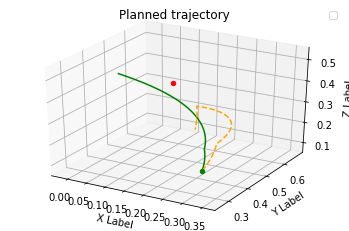

grasp_pos_dif 0.00047339850804141415
dispose_pos_dif 0.016153145548870932
tajectory generation time is 0.9639348983764648
grasp gen time is 40.427419900894165
movement time is 13.59690546989441
Total time {} 54.98826026916504


In [154]:
#load pos and orn from json file
with open('config/views_pos.json') as json_file:
    views_pos = json.load(json_file)

pos_dif = 1000
keys = views_pos.keys()
angle_range = [-140, 40]
pc_fused = []
pc_colors_fused = []
reference_pose = np.eye(4)
start_time = time.time()

for view_idx, key in enumerate(keys):
# while (not detected or not detected_with_collision):
    horizon = 30
    if abs(np.sum(np.array(rbt.model.ee_pos_rel()) - np.array(views_pos[key]["pos"]))) > 0.02:
        if pc_fused == []:
            target = key
        else:
            # Compute ROI
            pc_ROI, pc_colors_ROI, bounding_point = get_ROI_box(pc_fused, pc_colors_fused, depth_cv, rgb_cv, segmap, intrinsic, current_pose, border_size = 0.0)
            bestview, score = compute_views_scores(views, pc_fused, pc_colors_fused, intrinsic, bounding_point, image_size=(720, 1280))
            if score > 0.1:
                target = bestview
        view_jpos, view_x_pos, view_U, view_Ks, view_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, views_pos[target]["pos"], views_pos[target]["orn_wxyz"], horizon)

        if pos_dif > 0.035:
            print("Trajectory could not reach view continue to next view")
            continue

        view_U = np.array(view_U)
        success, idx, eef_pos, eef_quat = run_action(rbt, view_U, 20)
        rbt.active_controller.send_command(np.zeros(7))
        time.sleep(0.15)
    else:
        print( np.sum(np.array(rbt.model.ee_pos_rel()) - np.array(views_pos[key]["pos"])))
        print(np.array(views_pos[key]["pos"]))
        print(key)
    
    rbg_cv, depth_cv, depth_scale = camera.get_rgb_depth()
    depth_cv = depth_cv * depth_scale
 
    current_pose = get_camera_pose(rbt, ee_depth=-0.10340)

    if view_idx == 0:
        init_pos = rbt.model.ee_pos_rel()
        init_orn_wxyz = rbt.model.ee_orn_rel()
        reference_pose = get_camera_pose(rbt, ee_depth=-0.10340)
        depth_init = depth_cv
        rgb_init = rbg_cv
        pc_fused, pc_colors_fused = depth2pc(depth_init, intrinsic, rgb_init)
        pc_fused, pc_colors_fused = regularize_pc(pc_fused, pc_colors_fused, 
                                                  downsampling_method="voxel", voxel_size=0.005,
                                                  outlier_filtering_method="radius", radius_param_arg=[25, 0.015])
    else:
        pc_fused, pc_colors_fused = add_view2pc(pc_fused, pc_colors_fused, reference_pose, current_pose, new_gbr=rbg_cv, 
                                                new_depth=depth_cv, cam_intrisic=intrinsic, regularize=True, voxel_size=0.005)
    pc2_msg = format_pointcloud_msg(pc_fused, pc_colors_fused)
    bgr = cv2.cvtColor(rgb_init, cv2.COLOR_RGB2BGR)
    bgr_msg = bridge.cv2_to_imgmsg(rgb_init, encoding="bgr8")

    pc_preprocess_time = time.time()
    orn, pos, opening, score, detected, detected_with_collision = generate_grasps_client(pc2_msg, bgr_msg)

    if (detected or detected_with_collision) and opening > 0.03:
        grasp_pos_world, grasps_orn_world_xyzw = poseCam2World(pos, orn, reference_pose)      
        grasps_orn_world_xyzw = correct_angle(grasps_orn_world_xyzw, angle_range)
        grasp_orn_world_wxyz = convert_quat(grasps_orn_world_xyzw, to="wxyz")
        print("--------------------------------------------------------------------------")
        print("grasps in world frame :\n pos :", grasp_pos_world, "\n grasps_orn_world :", grasps_orn_world_xyzw, "\ngrasp world rot",  Rotation.from_quat(grasps_orn_world_xyzw).as_euler("XYZ", degrees=True))
        print("------------------------------------ --------------------------------------")
        break

grasp_gen_time = time.time()

# trajectory
#------------------------------------------------------------------

cell_pos, cell_idx = grid.get_first_free_cell()
if cell_pos is None:
    print("No free cell")
else:
    # cell_pos = cell_pose.position
    print(grid.get_disposability_grid())
    dispose_pos = cell_pos + np.array([0., 0., 0.035])
    dispose_orn_wxyz = np.array([0, 1, 0.35, 0]) 


grasp_horizon = 60
dispose_horizon = 75
grasp_pos_world = grasp_pos_world + np.array([0, 0, 0.01])
grasp_jpos, grasp_x_pos, grasp_U, grasp_Ks, grasp_ds, grasp_pos_dif, orn_dif = traj_gen.grasping_trajectory(rbt.q, rbt.dq, grasp_pos_world, grasp_orn_world_wxyz, grasp_horizon)
pos_threshold = 0.015
if pos_dif > pos_threshold:
    print("grasp trajectory error please change viewpose")
grasp_q = grasp_jpos[-1]
grasp_dq = np.zeros_like(grasp_q)
dispose_jpos, dispose_x_pos, dispose_U, dispose_Ks, dispose_ds, dispose_pos_dif, orn_dif = traj_gen.dispose_trajectory(grasp_q, grasp_dq, grasp_pos_world, grasp_orn_world_wxyz, dispose_pos, dispose_orn_wxyz, dispose_horizon)
iLQR.plot_trajectory(init_pos, grasp_pos_world, grasp_x_pos, dispose_x_pos)

print("grasp_pos_dif", grasp_pos_dif)
print("dispose_pos_dif", dispose_pos_dif)

if grasp_pos_dif < 0.01 and dispose_pos_dif < 0.04:
    grasp_U = np.array(grasp_U)
    grasp_U_shape = grasp_U.shape
    grasp_U = grasp_U[np.argwhere(np.sum(np.abs(grasp_U), axis=1) >= 1e-4)].squeeze(axis=1)
    dispose_U = np.array(dispose_U)
    dispose_U_shape = dispose_U.shape
    dispose_U = dispose_U[np.argwhere(np.sum(np.abs(dispose_U), axis=1) >= 1e-4)].squeeze(axis=1)

    traj_gen_time = time.time()

    # Move to the grasp pose
    if opening + 0.01 <= 0.08:
        rbt.gripper.move(width=opening + 0.01)
    else:
        rbt.gripper.move(width=0.08)

    # Grasp the object
    success, idx, eef_pos, eef_quat = run_action(rbt, grasp_U, 20)
    rbt.active_controller.send_command(np.zeros(7))
    rbt.gripper.move(width=opening-0.015)

    if rbt.error:
        print("robot encountered error")
        restart_controller(rbt)

    # Dispose the object
    success, idx, eef_pos, eef_quat = run_action(rbt, dispose_U, 20)
    rbt.active_controller.send_command(np.zeros(7))
    rbt.gripper.stop()

    rbt.gripper.move(width=0.082)

    # Register the object in the grid
    grid.set_cell_occupancy(cell_idx, 0)

    return_horizon = 45
    return_jpos, return_x_pos, return_U, return_Ks, return_ds, pos_dif, orn_dif = traj_gen.return_trajectory(rbt.q, rbt.dq, dispose_pos, dispose_orn_wxyz, init_pos, init_orn_wxyz, return_horizon)
    return_U = np.array(return_U)

    return_U_shape = return_U.shape
    return_U = return_U[np.argwhere(np.sum(np.abs(return_U), axis=1) >= 1e-5)].squeeze(axis=1)
    success, idx, eef_pos, eef_quat = run_action(rbt, return_U, 20)
    rbt.active_controller.send_command(np.zeros(7))

    if rbt.error:
        print("robot encountered error")
        restart_controller(rbt)


    print("tajectory generation time is {}".format(traj_gen_time - grasp_gen_time))
end_time = time.time()
print("grasp gen time is {}".format(grasp_gen_time - start_time))
print("movement time is {}".format(end_time - traj_gen_time))
print("Total time {}", end_time-start_time)

In [147]:
restart_controller(rbt)


[WARN] [1687973856.800683]: No controllers are running


[{'name': 'joint_velocity_controller', 'type': 'franka_ros_controllers/JointVelocityController'}]


In [92]:
restart_controller(rbt)
rbt.gripper.move(width=opening-0.015)

# Dispose the object
dispose_U = np.array(dispose_U)
success, idx, eef_pos, eef_quat = run_action(rbt, dispose_U, 20)
rbt.active_controller.send_command(np.zeros(7))
rbt.gripper.stop()
rbt.gripper.move(width=0.082)

# Register the object in the grid
grid.set_cell_occupancy(cell_idx, 0)


return_horizon = 45
return_jpos, return_x_pos, return_U, return_Ks, return_ds, pos_dif, orn_dif = traj_gen.return_trajectory(rbt.q, rbt.dq, dispose_pos, dispose_orn_wxyz, init_pos, init_orn_wxyz, return_horizon)
return_U = np.array(return_U)
success, idx, eef_pos, eef_quat = run_action(rbt, return_U, 20)
rbt.active_controller.send_command(np.zeros(7))

[WARN] [1687970578.871727]: No controllers are running


[{'name': 'joint_velocity_controller', 'type': 'franka_ros_controllers/JointVelocityController'}]


In [ ]:
rbt.stop_controller()

# inspect grid pos

In [ ]:
grid.clear_grid()

In [ ]:
cell_pos, cell_idx = grid.get_first_free_cell()
if cell_pos is None:
    print("No free cell")
else:
    # cell_pos = cell_pose.position
    print(grid.get_disposability_grid())
    grid_pos = cell_pos + np.array([0., 0., 0.05])
    grid_orn_wxyz = np.array([0, 1, 0.35, 0])

horizon = 30
grid_jpos, grid_x_pos, grid_U, grid_Ks, grid_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, grid_pos, grid_orn_wxyz, horizon)
grid_U = np.array(grid_U)
success, idx, eef_pos, eef_quat = run_action(rbt, grid_U, 20)
rbt.active_controller.send_command(np.zeros(7))
# Register the object in the grid
grid.set_cell_occupancy(cell_idx, 0)